# Research Question
<!-- What factors (such as model year, manufacturer brand, and electric range) are associated with higher electric vehicle (EV) registrations across different counties in Washington State? -->
Cna we reliably predict a county's electric vehicle (EV) registrations based of of vehicles' model year, manufacturer brand, electric range, and other factors in Washington State?

# Data Description 
We are using a dataset that shows the Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) that are currently registered through Washington State Department of Licensing (DOL). It provides key information about vehicle registrations, tax exemptions, and eligibility criteria for clean alternative fuel vehicles, and is updated regularly, with the monthly vehicle count subject to changes due to county assignment processes during registration. A Battery Electric Vehicle (BEV) is an all-electric vehicle using one or more batteries to store the electrical energy that powers the motor and is charged by plugging the vehicle in to an electric power source. A Plug-in Hybrid Electric Vehicle (PHEV) is a vehicle that uses one or more batteries to power an electric motor; uses another fuel, such as gasoline or diesel, to power an internal combustion engine or other propulsion source; and is charged by plugging the vehicle in to an electric power source.

The dataset consists of several columns representing various attributes related to each electric vehicle, including:
VIN: Vehicle Identification Number; County: The county where the vehicle is registered; City: The city where the vehicle is registered; State: The state (WA for Washington); Postal Code: The postal code of the registration; Model Year: The year the vehicle model was manufactured; Make: The manufacturer brand of the vehicle; Model: The model of the vehicle. Each row in the dataset describes a specific electric vehicle that is registered in Washington State.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, \
    KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, \
    mean_absolute_percentage_error, accuracy_score, precision_score, \
        recall_score, f1_score, precision_recall_curve
from sklearn import preprocessing


In [2]:
ev_df = pd.read_csv('Electric_Vehicle_Population_Data.csv', encoding='ISO-8859-1')
print(ev_df.shape)
ev_df.head()

(177866, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,POINT (-122.34848 47.632405),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,POINT (-122.03646 47.534065),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,23.0,205138552,POINT (-122.55717 47.733415),PUGET SOUND ENERGY INC,5.303594e+10


# Computing summary statistics

In [3]:
summary_statistics = ev_df[['Model Year', 'Electric Range']].describe()
print("Summary Statistics:\n", summary_statistics)

Summary Statistics:
           Model Year  Electric Range
count  177866.000000   177866.000000
mean     2020.515512       58.842162
std         2.989384       91.981298
min      1997.000000        0.000000
25%      2019.000000        0.000000
50%      2022.000000        0.000000
75%      2023.000000       75.000000
max      2024.000000      337.000000


Here we are getting the registration counts for each manufacturer to prepare for our analysis. Here we can see that Tesla has the most electric vehicle registrations, with Nissan coming second and Chevrolet coming third.

In [4]:
make_counts = ev_df['Make'].value_counts()
print("\nCount of EV registrations by manufacturer:\n", make_counts)


Count of EV registrations by manufacturer:
 Make
TESLA                   79659
NISSAN                  13998
CHEVROLET               13678
FORD                     9199
BMW                      7570
KIA                      7432
TOYOTA                   6288
VOLKSWAGEN               5004
JEEP                     4480
HYUNDAI                  4406
RIVIAN                   4312
VOLVO                    4133
AUDI                     3646
CHRYSLER                 2993
MERCEDES-BENZ            1589
PORSCHE                  1139
MITSUBISHI                958
MINI                      898
POLESTAR                  882
HONDA                     833
SUBARU                    831
FIAT                      784
DODGE                     568
MAZDA                     476
CADILLAC                  382
LEXUS                     370
SMART                     270
LINCOLN                   267
LUCID                     240
JAGUAR                    232
GENESIS                   182
LAND ROVER          

Here we am plotting the number of registered electric vehicles (EV) of each manufacturer. Based on the graph, we can confirm that Tesla seems to have produced the most number of EVs that are registered in Washington State.

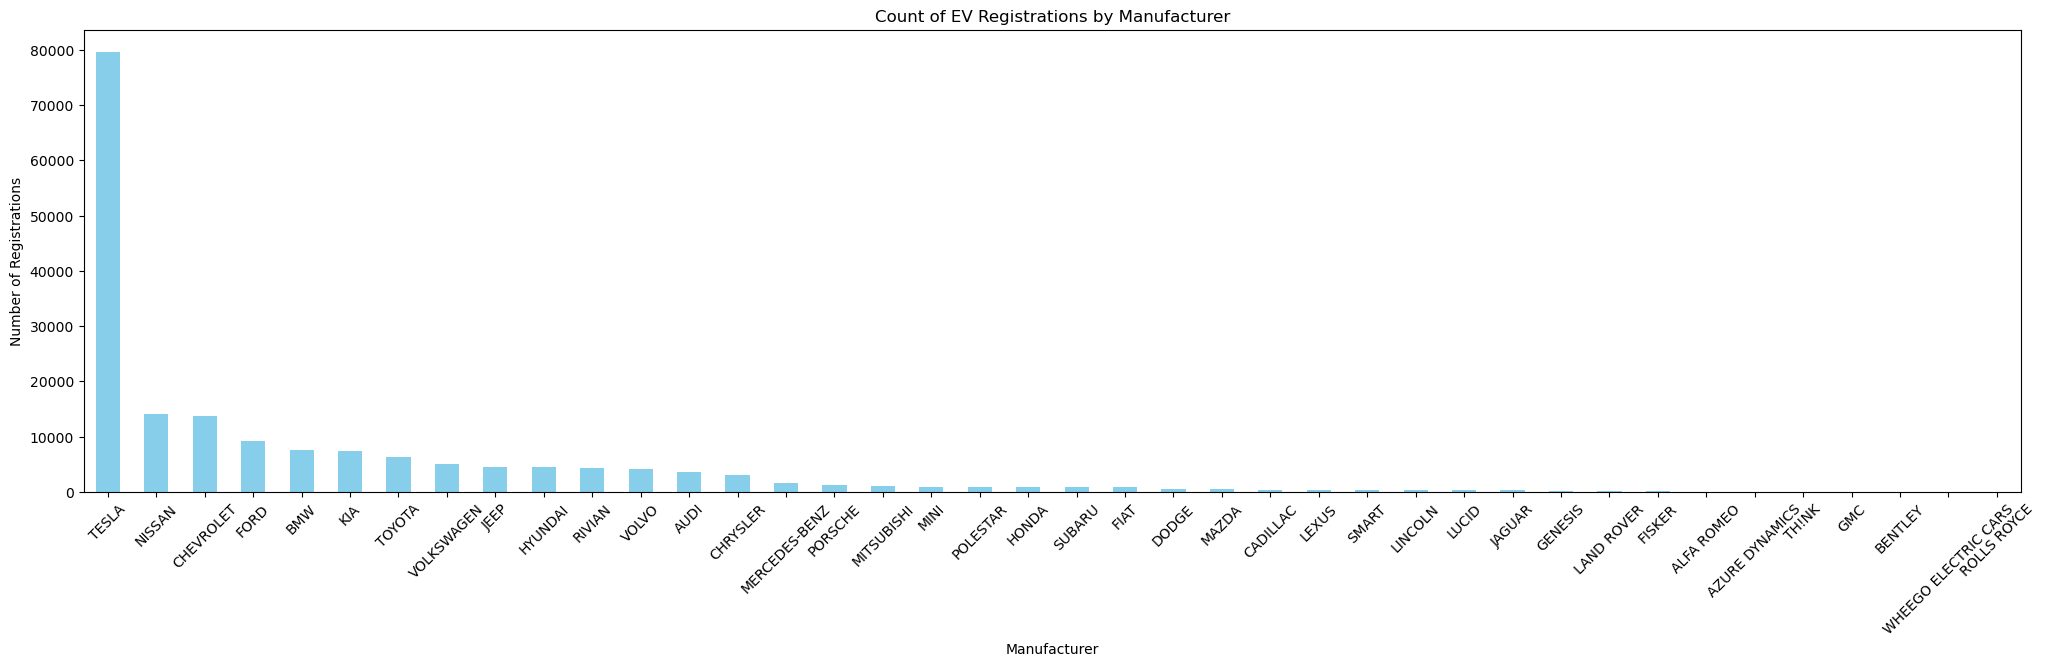

In [5]:
plt.figure(figsize=(25, 6))
make_counts.plot(kind='bar', color='skyblue')
plt.title('Count of EV Registrations by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.show()

The code below gets registration counts for different electric vehicle types to see if one is more popular than another. Based on the numbers, Battery Electric Vehicle (BEV) contains more EV registrations compared to Plug-in Hybrid Electric Vehicle (PHEV).

In [6]:
type_counts = ev_df['Electric Vehicle Type'].value_counts()
print("\nCount of EV registrations by manufacturer:\n", type_counts)


Count of EV registrations by manufacturer:
 Electric Vehicle Type
Battery Electric Vehicle (BEV)            139210
Plug-in Hybrid Electric Vehicle (PHEV)     38656
Name: count, dtype: int64


This code gets registration counts of EVs by the EV's model year. Based on the numbers, the 2023 models has the most registered EVs in Washington state.

In [7]:
year_counts = ev_df['Model Year'].value_counts().sort_index()
print("\nCount of EV registrations by Model Year:\n", year_counts)


Count of EV registrations by Model Year:
 Model Year
1997        1
1998        1
1999        5
2000        7
2002        2
2003        1
2008       20
2010       23
2011      775
2012     1618
2013     4409
2014     3509
2015     4844
2016     5483
2017     8562
2018    14323
2019    10940
2020    11768
2021    19132
2022    27776
2023    57587
2024     7080
Name: count, dtype: int64


We are plotting the number of registered EVs by the model year of each EV. The 2023 model is most registered in Washington State.

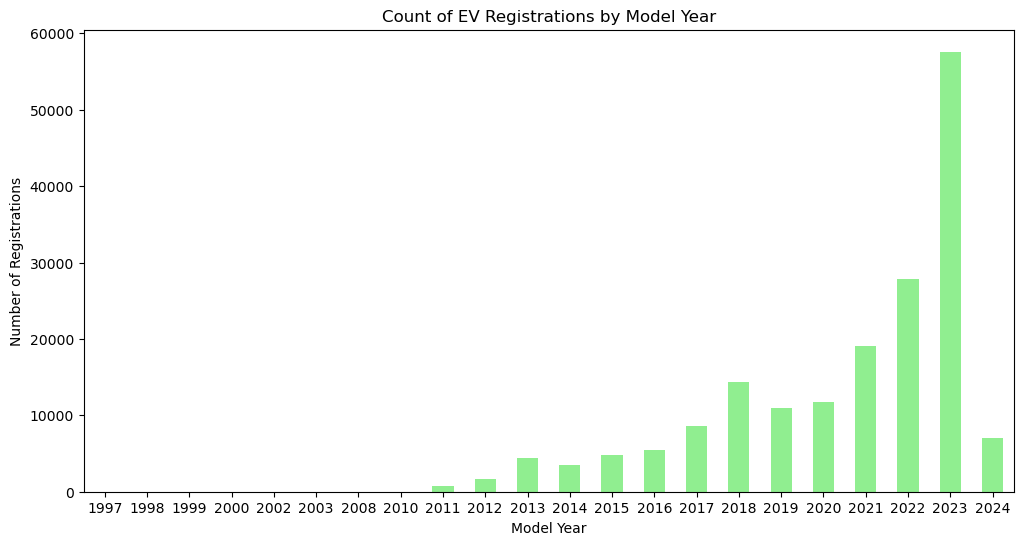

In [8]:
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color='lightgreen')
plt.title('Count of EV Registrations by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=0)
plt.show()

This code gets the registration counts of EV by Washington's legislative district.

In [9]:
district_counts = ev_df['Legislative District'].value_counts().sort_index()
print("\nCount of EV registrations by Model Year:\n", district_counts)


Count of EV registrations by Model Year:
 Legislative District
1.0      7786
2.0      2015
3.0       876
4.0      1470
5.0      7614
6.0      1691
7.0       839
8.0      1831
9.0      1003
10.0     3018
11.0     7507
12.0     1644
13.0     1211
14.0     1123
15.0      443
16.0      885
17.0     3000
18.0     4744
19.0     1032
20.0     1582
21.0     4410
22.0     4399
23.0     3830
24.0     2391
25.0     1838
26.0     3538
27.0     2522
28.0     2277
29.0     1183
30.0     2120
31.0     3100
32.0     4358
33.0     3550
34.0     5155
35.0     2488
36.0     7389
37.0     5215
38.0     1736
39.0     2593
40.0     3798
41.0    11553
42.0     2444
43.0     6524
44.0     4677
45.0    10737
46.0     6901
47.0     3230
48.0     9817
49.0     2390
Name: count, dtype: int64


We plotted the number of registered EV's in each legislative district in Washington state. It appears that District 41 has the most number of registered EVs. District 41 It covers all of Mercer Island and Newcastle, with portions of Bellevue, Renton, Issaquah, and Sammamish.

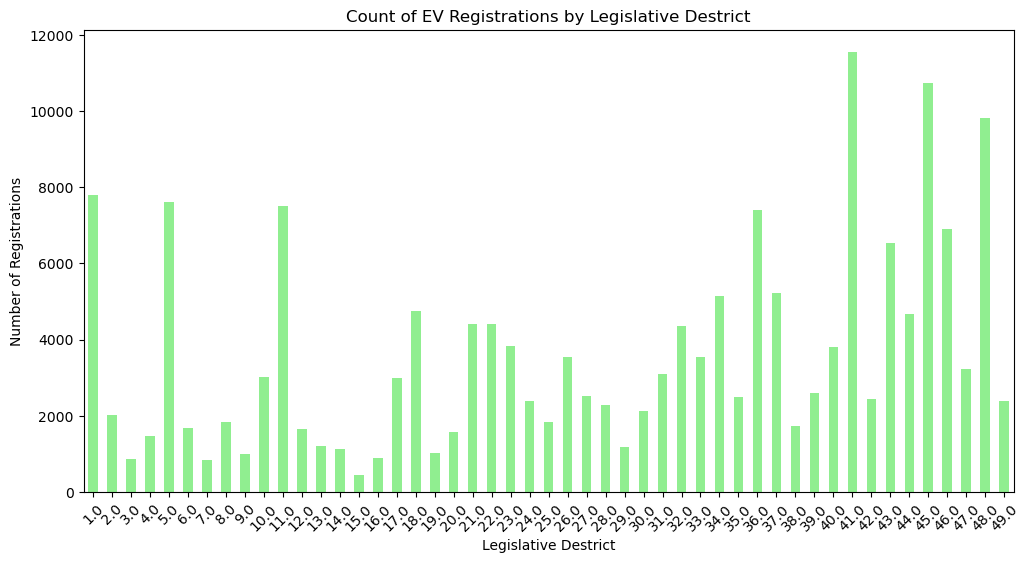

In [10]:
plt.figure(figsize=(12, 6))
district_counts.plot(kind='bar', color='lightgreen')
plt.title('Count of EV Registrations by Legislative Destrict')
plt.xlabel('Legislative Destrict')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.show()

### Filtering Data ###
While looking over our dataset, we observed that some of the electric range was 0. It is nonsensical to drive negative distance, so we filtered out data that contained electric range that was <= 0.

In [11]:
# Dropping missing data values
# Ensuring the electric range is positive because it is nonsensical to drive negative distance
# Setting model year as an integer to reinforce data type in preparation for plots
ev_df = ev_df.dropna(subset=['County', 'Model Year', 'Make', 'Electric Vehicle Type', 'Electric Range'])
ev_df = ev_df[ev_df['Electric Range'] > 0]
ev_df['Model Year'] = ev_df['Model Year'].astype(int)

In [12]:
# Filtering county and EV registration count, grouping by county
county_ev_counts = duckdb.sql("""
    SELECT County, COUNT(*) AS "EV Count",
    AVG("Electric Range") AS "Average Electric Range",
    FROM ev_df
    GROUP BY County
""").df()

In [13]:
# Dataframe to compare Model Year and EV registrations
model_year_ev_counts = duckdb.sql("""
    SELECT "Model Year", 
    COUNT(*) AS "Total EV Registrations"
    FROM ev_df
    GROUP BY "Model Year"
    ORDER BY "Model Year"
""").df()

### Filtering Data ###
When looking over counties, we decided to filter out counties that had less than 20 electric vehicle registrations. Counties with very few EVs may skew the results by introducing noise or outliers that are not representative of broader trends.

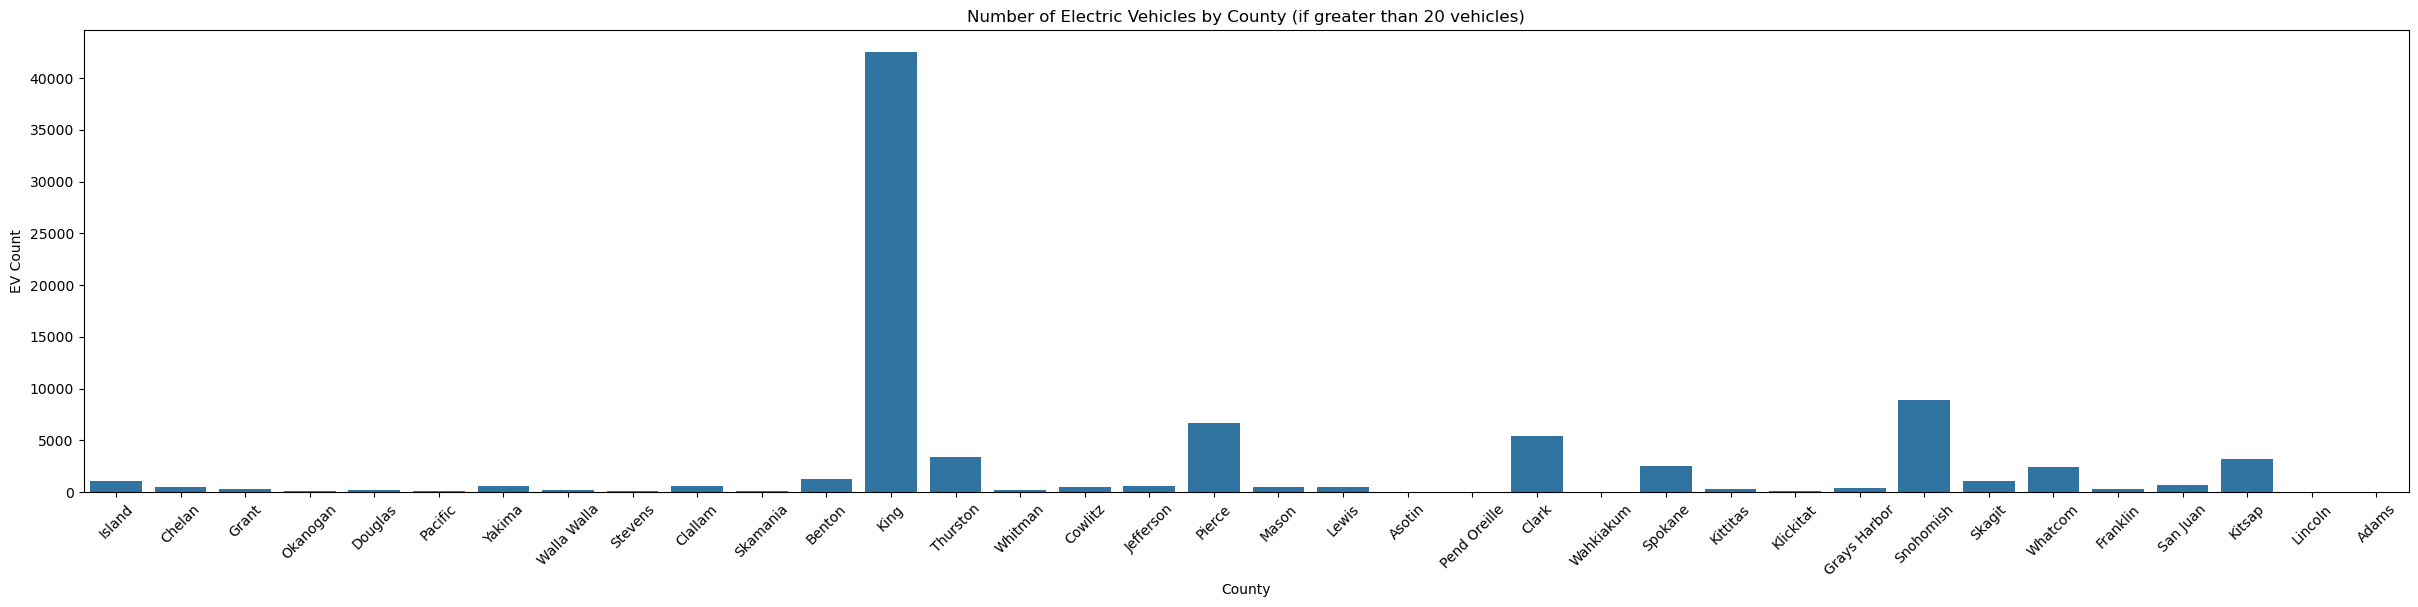

In [14]:
plt.figure(figsize=(30, 6))

# Cleaning data, count < 20 are considered outliers, so we are disregarding counties with less than 20 ev
county_ev_counts = county_ev_counts[county_ev_counts['EV Count'] > 20]

# Plotting number of registered EVs based on counties in Washington State, omitting counties with 
# registrations less than 20 to prevent effects of outliers on data interpretation. 
# King's County has the most number of registered EVs. It is the most populated country in Washington, with ~2M people. 
# King County also contains Seattle, the county seat and most populous city in Washington.
sns.barplot(x='County', y= 'EV Count', data=county_ev_counts, errorbar=None)
plt.xticks(rotation=45)
plt.title('Number of Electric Vehicles by County (if greater than 20 vehicles)')
plt.ylabel('EV Count')
plt.xlabel('County')
plt.show()

We plotted the average electric range of EVs compared to the number of registered EVs for counties that have registered EVs > 20. Electric range is the distance an electric vehicle (EV) can travel on a single charge. There seems to be a higher density of electric vehicles with ranges below 100 miles, as seen by the concentration of points in this region. Based on the graph, there's no clear linear or direct correlation between electric range and EV count in this plot. Based on this graph alone, it seems that the popularity of EVs is not necessarily tied to longer electric ranges.

Text(0.5, 1.0, 'EV Count vs Average Electric Range for Counties')

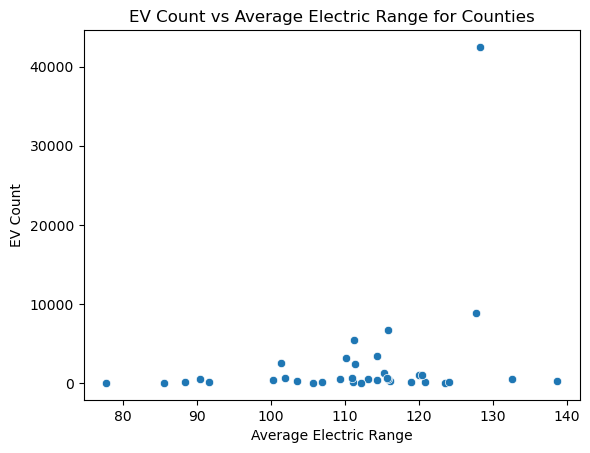

In [15]:
sns.scatterplot(x='Average Electric Range', y='EV Count', data=county_ev_counts)
plt.title('EV Count vs Average Electric Range for Counties')

# Regression Analysis
Here we are planning to analyze the relationship between factors like model year, electric range, and base MSRP and the number of registered EVs.

In [24]:
# Analyzing how electric range are associated with the number of registered EVs.
X = county_ev_counts[['Average Electric Range']]
y = county_ev_counts['EV Count']

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
slope = reg_model.coef_
intercept = reg_model.intercept_

print("Slope", slope)
print("Intercept", intercept)

Slope [149.37588941]
Intercept -14235.491191560199


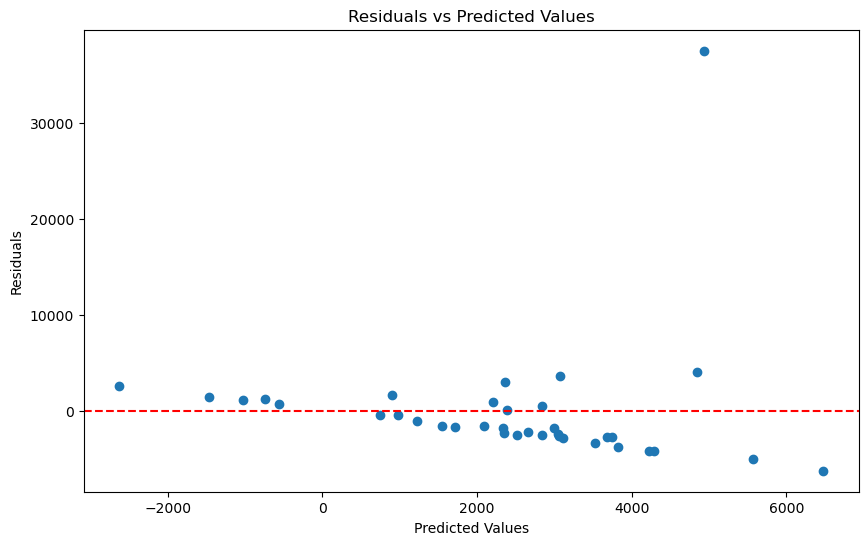

In [25]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

Slope (Coefficients): [282.88875171]
Intercept: -566235.2477366256
Mean Squared Error (MSE): 4482.874844877962
Root Mean Squared Error (RMSE): 66.95427428385705


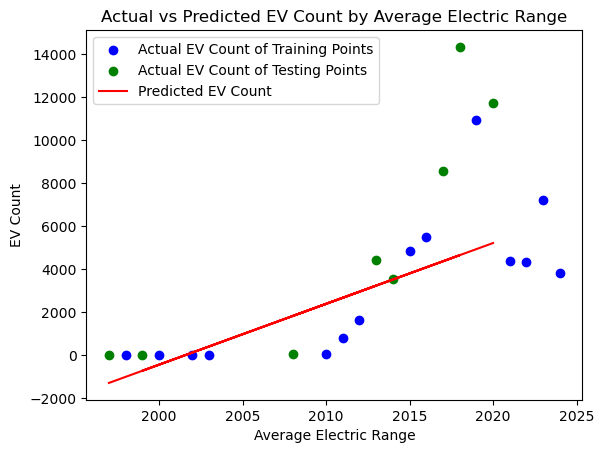

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

slope = reg_model.coef_
intercept = reg_model.intercept_

mse = root_mean_squared_error(y_test, y_pred)
print("Slope (Coefficients):", slope)
print("Intercept:", intercept)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
plt.scatter(X_train, y_train, color="blue", label="Actual EV Count of Training Points")
plt.scatter(X_test, y_test, color="green", label="Actual EV Count of Testing Points")
plt.plot(X_test, y_pred, color="red", label="Predicted EV Count")
plt.title('Actual vs Predicted EV Count by Average Electric Range')
plt.xlabel('Average Electric Range')
plt.ylabel('EV Count')
plt.legend()
plt.show()

The scatter plot shows:
- Blue Points: Actual EV Counts from the training data.
- Green Points: Actual EV Counts from the testing data.
- Red Line: The model's predicted EV Count based on the average electric range in the test set.

The slope of 211.70 means that for every unit increase in the Average Electric Range, the predicted number of EV registrations (EV Count) increases by approximately 211.7 units, assuming other factors remain constant. <br> The MSE is 3211.45, which indicates that there is some error in the predictions.



In [42]:
X = model_year_ev_counts[['Model Year']]
y = model_year_ev_counts['Total EV Registrations']

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
slope = reg_model.coef_
intercept = reg_model.intercept_

print("Slope", slope)
print("Intercept", intercept)

Slope [353.67364137]
Intercept -707654.1688259576


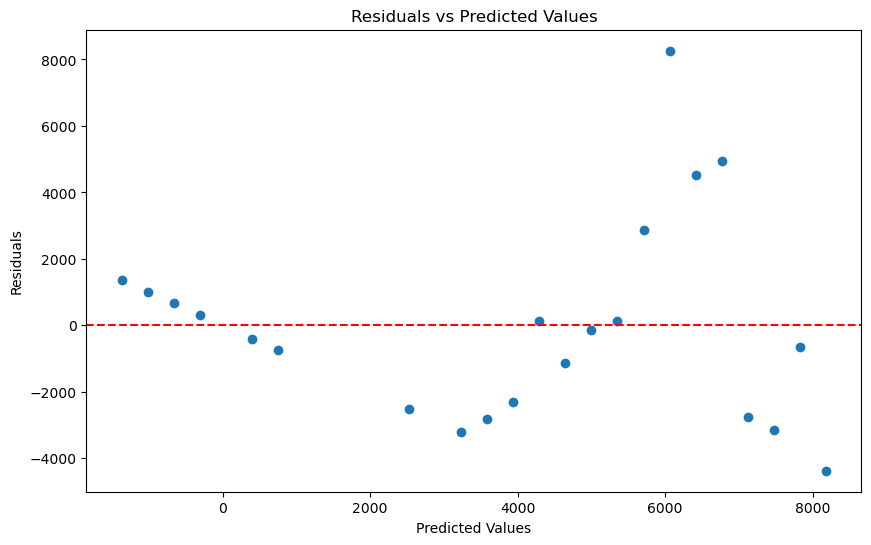

In [36]:
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

Slope (Coefficients): [282.88875171]
Intercept: -566235.2477366256
Mean Squared Error (MSE): 4482.874844877962
Root Mean Squared Error (RMSE): 66.95427428385705


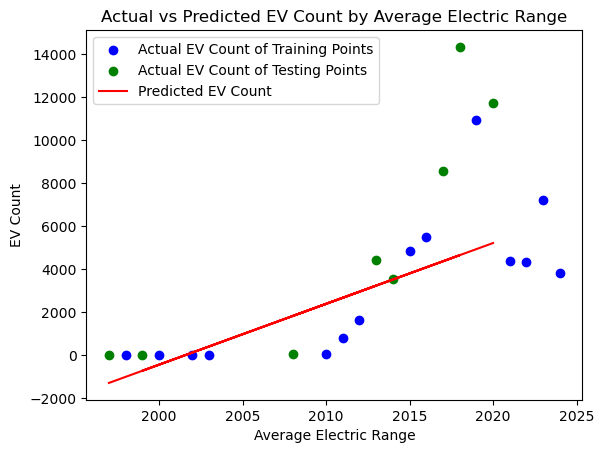

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

slope = reg_model.coef_
intercept = reg_model.intercept_

mse = root_mean_squared_error(y_test, y_pred)
print("Slope (Coefficients):", slope)
print("Intercept:", intercept)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
slope = reg_model.coef_
intercept = reg_model.intercept_

plt.scatter(X_train, y_train, color="blue", label="Actual EV Count of Training Points")
plt.scatter(X_test, y_test, color="green", label="Actual EV Count of Testing Points")
plt.plot(X_test, y_pred, color="red", label="Predicted EV Count")
plt.title('Actual vs Predicted EV Count by Average Electric Range')
plt.xlabel('Average Electric Range')
plt.ylabel('EV Count')
plt.legend()
plt.show()

The increasing number of EV registrations with newer model years reflects a trend where EVs are gaining popularity as technology improves and becomes more accessible.

The slope of 282.89 means that for every one-year increase in the Model Year, the Total EV Registrations are predicted to increase by approximately 282.9 units. On average, the predicted number of EV Registrations deviates from the actual values by about 67 registrations.

# Result Discussion
Based on the graphs that we have displayed, it seems that most individuals within Washington State that registered their EVs have newer models (2023 model) as well as a Tesla. 
Tesla has the most registered EVs in Washington, with Nissan and Chevrolet following in second and third places. This trend was visualized using a bar chart that highlights Tesla's dominance in the Washington EV market.

Battery Electric Vehicles (BEVs) significantly outnumber Plug-in Hybrid Electric Vehicles (PHEVs) in Washington, with over 139,000 BEVs and about 38,000 PHEVs.

The 2023 model year has the highest number of EV registrations, confirming a growing interest in newer electric vehicles. Older models ( 1997-2011) have significantly fewer registrations, while there is a steady increase from 2012 onwards, with 2023 being a standout year.


In the Linear Regression on EV Count vs. Average Electric Range, the model showed a positive relationship between the average electric range of vehicles and the total count of EVs. The Mean Squared Error (MSE) of 3211.45 suggests that there is considerable prediction error in this model. While the model captures the positive trend between range and EV count, the high error indicates that average electric range alone is insufficient to understand our research question. Other factors likely play a significant role, and adding those could improve model accuracy.
<br>In the Linear Regression on EV Registrations vs. Model Year, the model suggested that newer vehicle models are associated with higher registration numbers. Both models are single-variable linear regression and may be too simplistic to fully explain the variability in the data.


# Data Limitations
There are some limitations in our dataset.
1. Missing Values: Some fields may contain missing values, particularly for Electric Range and Base MSRP.
2. The presence of outliers in the Base MSRP and Electric Range columns may skew results and influence statistical analyses.
3. The dataset does not take into account other factors that can influence registration of electric vehicles, such as accessibility to a dealership that sells electric vehicles. Some smaller counties may have access to limited kinds of cars that could have affected registration count. 

# Questions for Reviewers
1. What additional exploratory data analysis techniques would you suggest to uncover deeper insights?
2. Do you have recommendations for more advanced statistical methods or models that could improve the analysis?
3. Have we identified all relevant data limitations, or are there other concerns that I should consider?
4. Do you have any suggestions on how we can improve our regression analysis?
5. Do you suggest utilizing more datasets to enhance our research question?